#### Analysis and model creation for the titanic data set, meant to predict the chance of survival of members of a test set of passengers on the Titanic based on a sample of labeled training data.

Note: The work in this notebook largely matches the solution provided for working with the Titanic data set in Aurelien Geron's book, "Hands-On ML".

In [1]:
import numpy as np
import pandas as pd
import os

DEFAULT_PATH = "./"

def load_data(filename, path=DEFAULT_PATH):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

In [2]:
train_data = load_data("train.csv")
test_data = load_data("test.csv")

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes):
        self.attributes = attributes
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attributes]

In [7]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
test_data["RelativesOnboard"] = test_data["SibSp"] + test_data["Parch"]

train_data["AgeCategory"] = train_data["Age"] // 15
test_data["AgeCategory"] = test_data["Age"] // 15

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("numeric_attributes", DataFrameSelector(["Age", "Fare", "SibSp", "Parch"])),
    ("imputer", SimpleImputer(strategy="median"))
])

In [9]:
num_pipeline.fit_transform(train_data)

array([[22.    ,  7.25  ,  1.    ,  0.    ],
       [38.    , 71.2833,  1.    ,  0.    ],
       [26.    ,  7.925 ,  0.    ,  0.    ],
       ...,
       [28.    , 23.45  ,  1.    ,  2.    ],
       [26.    , 30.    ,  0.    ,  0.    ],
       [32.    ,  7.75  ,  0.    ,  0.    ]])

In [10]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_values_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    
    def transform(self, X):
        return X.fillna(self.most_frequent_values_)

In [11]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ("categorical_attributes", DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ("cat_encoder", OneHotEncoder(sparse=False)),
])

In [12]:
cat_pipeline.fit_transform(train_data)

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [13]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion([
    ("num_attr", num_pipeline),
    ("cat_attr", cat_pipeline),
])

In [14]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[22.    ,  7.25  ,  1.    , ...,  0.    ,  0.    ,  1.    ],
       [38.    , 71.2833,  1.    , ...,  1.    ,  0.    ,  0.    ],
       [26.    ,  7.925 ,  0.    , ...,  0.    ,  0.    ,  1.    ],
       ...,
       [28.    , 23.45  ,  1.    , ...,  0.    ,  0.    ,  1.    ],
       [26.    , 30.    ,  0.    , ...,  1.    ,  0.    ,  0.    ],
       [32.    ,  7.75  ,  0.    , ...,  0.    ,  1.    ,  0.    ]])

In [15]:
y_train = train_data["Survived"]
y_train

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [16]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [17]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

In [18]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

In [19]:
from sklearn.ensemble import RandomForestClassifier

rfc_clf = RandomForestClassifier(n_estimators=100, random_state=11)
rfc_scores = cross_val_score(rfc_clf, X_train, y_train, cv=10)
rfc_scores.mean()

0.8160299625468165

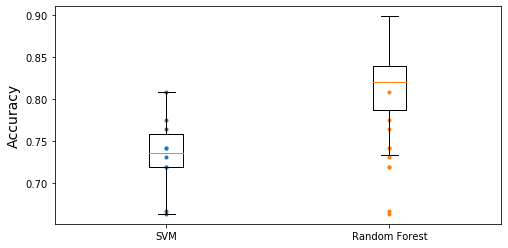

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot([1] * 10, svm_scores, ".")
plt.plot([2] * 10, svm_scores, ".")
plt.boxplot([svm_scores, rfc_scores], labels=("SVM", "Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()

In [21]:
from sklearn.model_selection import GridSearchCV

other_forest_clf = RandomForestClassifier(random_state=11)
gs = GridSearchCV(other_forest_clf, {
    "min_samples_split": [ 2, 3, 4, 5],
    "max_depth": [ 3, 6, 12, 24, None ]
})
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=11,
                               

In [22]:
gs.cv_results_

{'mean_fit_time': array([0.10802326, 0.09990306, 0.10277991, 0.09935269, 0.10637398,
        0.10526686, 0.10575194, 0.10513148, 0.11465945, 0.11441164,
        0.11603169, 0.11256318, 0.1163497 , 0.12365623, 0.11644731,
        0.11473379, 0.12211347, 0.11691241, 0.11652474, 0.11578984]),
 'std_fit_time': array([0.00993932, 0.00200476, 0.00370941, 0.0003087 , 0.00111643,
        0.0002463 , 0.00060843, 0.00012855, 0.00090184, 0.00071064,
        0.0030461 , 0.00038027, 0.00067384, 0.00979414, 0.00136541,
        0.00087313, 0.00739527, 0.00105451, 0.00069108, 0.00133975]),
 'mean_score_time': array([0.00775356, 0.00714974, 0.00772247, 0.00715342, 0.00774493,
        0.0075388 , 0.00754371, 0.00751944, 0.00809798, 0.00806937,
        0.00811257, 0.00810499, 0.00821824, 0.00888681, 0.00815983,
        0.00818591, 0.00874882, 0.00835118, 0.00817671, 0.00818658]),
 'std_score_time': array([7.65272053e-04, 6.35574744e-05, 1.11292557e-03, 5.17643139e-05,
        2.24778356e-04, 1.36049923e-

In [23]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=11, verbose=0,
                       warm_start=False)

In [24]:
cv_rfc_scores = cross_val_score(gs, X_train, y_train, cv=10)
cv_rfc_scores

array([0.8       , 0.82022472, 0.74157303, 0.87640449, 0.91011236,
       0.80898876, 0.83146067, 0.79775281, 0.87640449, 0.85393258])

In [25]:
cv_rfc_scores.mean()

0.8316853932584269